In [12]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.lines import Line2D

import pandas as pd
import linmix
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr


In [2]:
data = pd.read_csv('data/HRvsAge_Median+STD+Bounds.csv')
data.head(3)

,SNID,Age_global,Age_global_err,HR,HR_err,Age_median,Age_lower,Age_upper
0,762,8.0,3.9,0.15,0.08,7.970196,1.769602,9.530263
1,1032,8.6,4.3,-0.15,0.12,8.617191,1.753334,10.272933
2,1371,8.1,1.3,-0.14,0.06,8.071166,6.613812,9.277128


In [3]:
# prepare an array for uneven errorbars
xerr = np.array([data['Age_median'].values - data['Age_lower'].values ,data['Age_upper'].values - data['Age_median'].values])

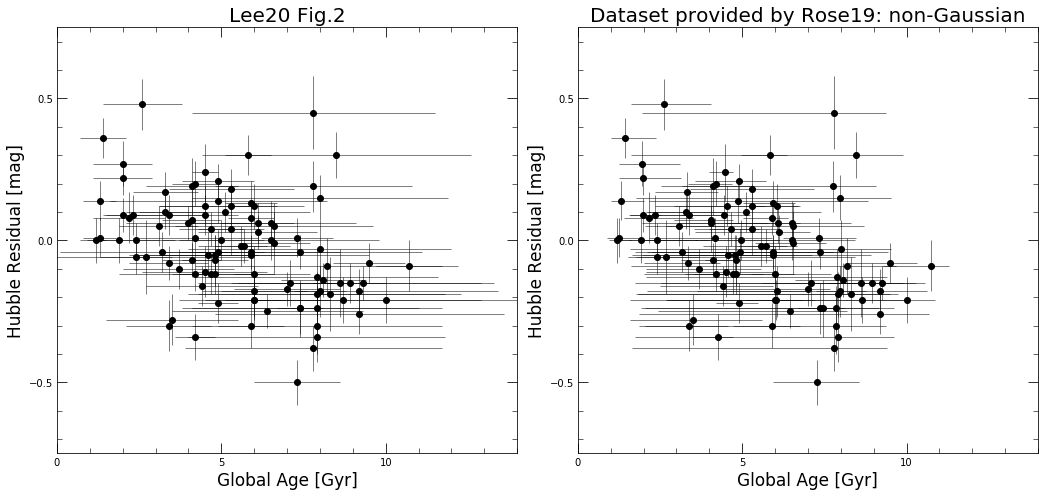

In [4]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

ax1.errorbar(data['Age_global'],data['HR'],yerr=data['HR_err'],xerr=data['Age_global_err'],fmt='ko',lw=0.5)
ax2.errorbar(data['Age_median'],data['HR'],yerr=data['HR_err'],xerr=xerr,fmt='ko',lw=0.5)

ax1.set_title('Lee20 Fig.2',fontsize=20)
ax2.set_title('Dataset provided by Rose19: non-Gaussian',fontsize=20)
for ax in [ax1,ax2]:
    ax.set_xlabel('Global Age [Gyr]',fontsize=17)
    ax.set_ylabel('Hubble Residual [mag]',fontsize=17)
    ax.set_xlim(0,14)
    ax.set_ylim(-0.75,0.75)
    ax.tick_params(which='major', length=10, direction='in',right=True,top=True)
    ax.tick_params(which='minor', length=5, direction='in',right=True,top=True)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.tight_layout()

## (1-2) MCMC posterior

In [5]:
dataset = 'campbell'   # 'gupta' or 'campbell' or 'campbellG'
filename = 'data/HRvsAge_samples_campbell10k.csv'

In [6]:
samples = pd.read_csv(filename)
samples.head(3)

,SNID,Age0,Age1,Age2,Age3,Age4,Age5,Age6,Age7,Age8,...,HR9990,HR9991,HR9992,HR9993,HR9994,HR9995,HR9996,HR9997,HR9998,HR9999
0,762,4.758532,1.558216,7.348196,4.922079,1.916873,8.067425,8.161599,3.595067,1.897597,...,0.125418,0.111031,0.049721,0.110228,0.061907,0.042606,0.070339,0.103706,0.087285,0.080275
1,1032,7.493606,10.350519,6.692530,5.663809,8.046976,3.958073,2.291889,3.648609,6.861651,...,-0.025980,-0.018704,0.003307,0.020747,-0.027311,-0.010247,-0.025592,0.028176,0.019976,-0.030866
2,1371,1.844475,9.785429,0.805218,10.507561,9.964770,9.645604,10.331896,2.330517,1.195014,...,-0.178016,-0.191690,-0.131175,-0.215081,-0.206989,-0.186684,-0.159390,-0.179546,-0.180692,-0.214565


In [7]:
num_samples = 10000 # 10k samples
length = 103
age_columns = ['Age{}'.format(i) for i in range(num_samples)]
HR_columns  = ['HR{}'.format(i) for i in range(num_samples)]

# put them together
Age_all = samples[age_columns].values.flatten()
HR_all = samples[HR_columns].values.flatten()

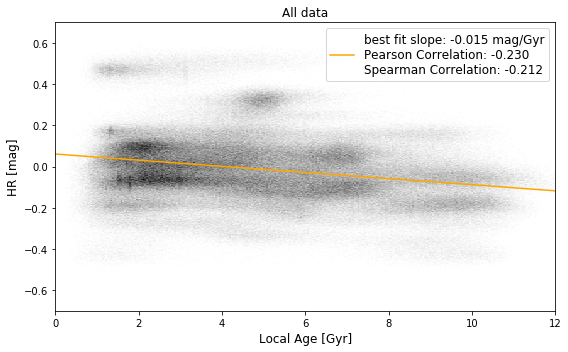

In [8]:
Nbins = 300
cmap = 'gray_r'
x_th = np.linspace(0,14,10)

fig,(ax1) = plt.subplots(1,1,figsize=(8,5))

# Calculate correlations and slope for all
corr = stats.pearsonr(Age_all, HR_all)[0]
rank_corr = stats.spearmanr(Age_all, HR_all)[0]
popt,_ = curve_fit(lambda x,a,b: a*x+b, Age_all, HR_all)
y_th = x_th * popt[0] + popt[1]

ax1.plot(x_th,y_th,c='orange', label=f"best fit slope: {popt[0]:.3f} mag/Gyr\nPearson Correlation: {corr:.3f}\nSpearman Correlation: {rank_corr:.3f}")
ax1.hist2d(Age_all, HR_all,bins=Nbins,cmap=cmap)
ax1.set_title('All data')


for ax in [ax1]:
    ax.legend(fontsize=12)
    ax.set_xlabel('Local Age [Gyr]',fontsize=12)
    ax.set_ylabel('HR [mag]',fontsize=12)
    ax.set_xlim(0,12)
    ax.set_ylim(-0.7,0.7)
plt.tight_layout()

# (2) LINMIX

In [44]:
K = 2
seed = 2

In [46]:
lm1 = linmix.LinMix(data['Age_global'],data['HR'],data['Age_global_err'],data['HR_err'], K=K,seed=seed)
lm1.run_mcmc(silent=True)

In [10]:
lm2 = linmix.LinMix(Age_all[::10], HR_all[::10], K=K,seed=seed)
lm2.run_mcmc()#silent=True)


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99264332 0.99105927 1.00517012 0.99277727 0.99786872 0.99060106]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99742432 0.99784237 1.00204454 0.99950991 1.00310082 0.99749932]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99889304 0.99982632 1.00392484 1.00212863 1.00203398 0.99956125]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00051949 1.0007006  1.00204601 1.00332593 1.0009061  1.00008825]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99973675 0.99989109 1.00031087 1.00062553 0.99995243 0.99951381]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00002061 1.00021439 0

In [47]:
def odr_fit(xdata,ydata,xerr=None,yerr=None):
    curve_odr = odr.Model(lambda PARAM,x: x*PARAM[0] + PARAM[1])
    data = odr.RealData(xdata,ydata,sx=xerr, sy=yerr)
    odr_obj = odr.ODR(data, curve_odr, beta0=[0., 0.])
    out = odr_obj.run()
    popt = out.beta
    pcov = out.sd_beta
    return popt,pcov

In [49]:
def linear(x,a,b):
    return a*x + b

In [48]:
popt1,_ = odr_fit(data['Age_global'],data['HR'],data['Age_global_err'],data['HR_err'])
popt2,_ = odr_fit(Age_all, HR_all)

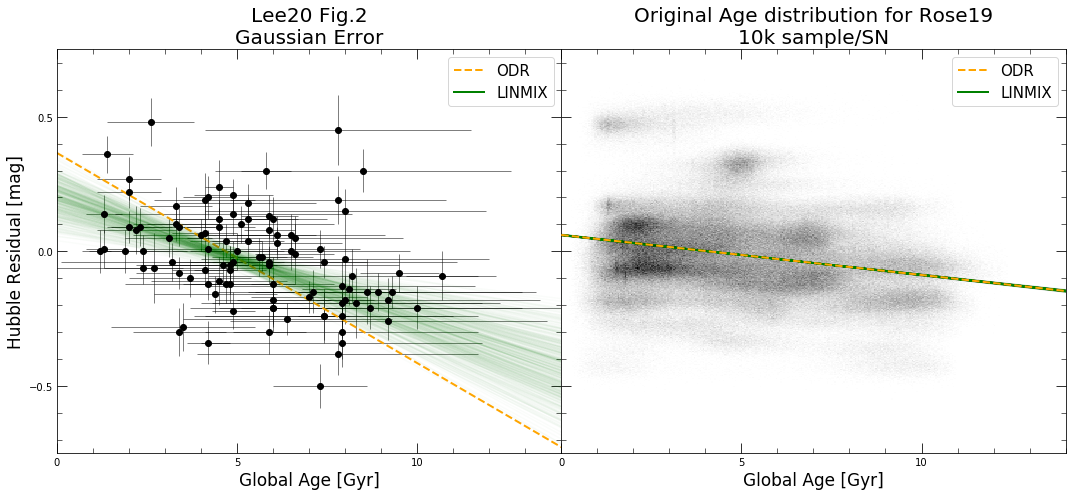

In [54]:
x_th = np.linspace(0,14,10)

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

# data
ax1.errorbar(data['Age_global'],data['HR'],yerr=data['HR_err'],xerr=data['Age_global_err'],fmt='ko',lw=0.5)
ax2.hist2d(Age_all, HR_all,bins=Nbins,cmap=cmap)

# ODR
ax1.plot(x_th,linear(x_th,*popt1),c='orange',lw=2, label="ODR",linestyle='--')
ax2.plot(x_th,y_th,c='orange', lw=2,linestyle='--',zorder=4)

# LINMIX
for i in range(0, len(lm.chain), 25):
    xs = np.arange(0,15)
    ys1 = lm1.chain[i]['alpha'] + xs * lm1.chain[i]['beta']
    ys2 = lm2.chain[i]['alpha'] + xs * lm2.chain[i]['beta']
    ax1.plot(xs, ys1, color='g', alpha=0.02)
    ax2.plot(xs, ys2, color='g', alpha=0.02)

# prettifying
ax1.set_title('Lee20 Fig.2\nGaussian Error',fontsize=20)
ax2.set_title('Original Age distribution for Rose19\n10k sample/SN',fontsize=20)
ax1.set_ylabel('Hubble Residual [mag]',fontsize=17)
ax2.axes.yaxis.set_ticklabels([])
for ax in [ax1,ax2]:
    ax.set_xlabel('Global Age [Gyr]',fontsize=17)
    ax.set_xlim(0,14)
    ax.set_ylim(-0.75,0.75)
    ax.tick_params(which='major', length=10, direction='in',right=True,top=True)
    ax.tick_params(which='minor', length=5, direction='in',right=True,top=True)
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# quick and dirty solution to make legends
trend_odr = Line2D([0],[0], c='orange', lw=2, label="ODR",linestyle='--')
trend_linmix = Line2D([0], [0], color='g', lw=2, label='LINMIX')
ax1.legend(handles=[trend_odr,trend_linmix],fontsize=15)
ax2.legend(handles=[trend_odr,trend_linmix],fontsize=15)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('figures/ODRvsLINMIX.png',dpi=100)

In [14]:
test = [0.4,
 0.1,
 0.3,
 0.25,
 0.1,
 0.4,
 0.1,
 0.4,
 0.1,
 0.85,
 0.2,
 0.9,
 0.5,
 0.4,
 0.4,
 0.7,
 0.4,
 0.6,
 0.6,
 0.3,
 0.65,
 0.95,
 0.5,
 0.1,
 0.8,
 0.98,
 0.1,
 0.2,
 0.15,
 0.75,
 0.15,
 0.6,
 0.2,
 0.4,
 0.2,
 0.7,
 0.1,
 0.85,
 0.6,
 0.9,
 0.6,
 0.7,
 0.35,
 0.4,
 0.45,
 0.5,
 0.6,
 0.4,
 0.7,
 0.45,
 0.8,
 0.65,
 0.35,
 0.7,
 0.3,
 0.9,
 0.8,
 0.45,
 0.55,
 0.7,
 0.3,
 0.85,
 0.65,
 0.3,
 0.15,
 0.9,
 0.85,
 0.6,
 0.3,
 0.65,
 0.4,
 0.8,
 0.75,
 0.45,
 0.8,
 0.55,
 0.8,
 0.8,
 0.6,
 0.1,
 0.45,
 0.8,
 0.9,
 0.35,
 0.7,
 0.95,
 0.1,
 0.75,
 0.8,
 0.25,
 0.2,
 0.85,
 0.9,
 0.6,
 0.25,
 0.5,
 0.2,
 0.8,
 0.8]

(array([12.,  9.,  9., 15.,  4., 11., 11., 14.,  5.,  9.]),
 array([0.1  , 0.188, 0.276, 0.364, 0.452, 0.54 , 0.628, 0.716, 0.804,
        0.892, 0.98 ]),
 <a list of 10 Patch objects>)

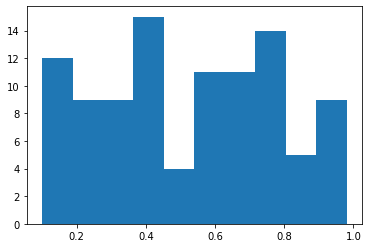

In [15]:
plt.hist(test)

In [17]:
len(test)

99